<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Bankhead National Forest - CMAC/RadClss Rain Rates Investigation

## Overview

The Corrected Moments to Antenna Coordinates (CMAC) Value-Added Product (VAP) is designed to provide a quality assured dataset which includes pre-processing and corrections for the significant influence of attenuation in rain, specific differential phase measurements to better account for non-uniform beam filling and anticipated beam blockage, and the anticipated need to de-aliasing Doppler velocities in severe convective cloud contexts 

The Extracted Radar Columns and In-Situ Sensors (RadClss) Value-Added Product (VAP) is
a dataset containing in-situ ground observations matched to CSAPR-2 radar columns above ARM Mobile Facility (AMF-3) supplemental sites of interest. 

Together, these products allow for the investigation of radar derived rain rates within BNF. 

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [GeoPandas](https://geopandas.org/en/stable/docs.html) | Necessary | Familiarity with Geospatial Plotting|
| [Py-ART / Radar Foundations](https://projectpythia.org/radar-cookbook/README.html) | Necessary | Basics of Weather Radar | 

- **Time to learn**: 30 minutes

## Current List of Supported RadCLss Sites
| Site  | Lat   | Lon   |
| ----- | ----- | ----- |
| M1    | 34.34525 | -87.33842 |
| S4    | 34.46451 | -87.23598 |
| S20   | 34.65401 | -87.29264 |
| S30   | 34.38501 | -86.92757 |
| S40   | 34.17932 | -87.45349 |



<img src="images/bnf-radar-display-5March2025.png" width=1500 alt="BNF Radar Display"></img>

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask
import cartopy.crs as ccrs

from math import atan2 as atan2
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from dask.distributed import Client, LocalCluster
from metpy.plots import USCOUNTIES

import act
import pyart

dask.config.set({'logging.distributed': 'error'})


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Define Processing Variables

In [3]:
# Define the desired processing date for the BNF CSAPR-2 in YYYY-MM-DD format.
DATE = "2025-03-05"
# Define the directory where the BNF CSAPR-2 CMAC files are located.
RADAR_DIR = "/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/"
# Define an output directory for downloaded ground instrumentation
INSITU_DIR = "/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/in_situ/"

In [ ]:
# Define the RadCLss file
RADCLSS = sorted(glob.glob("data/bnf-csapr2-radclss.c2." + "*" + DATE.replace('-', '') + '*.nc'))

## Define Functions 

In [18]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 3.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

In [15]:
def bnf_display(radar):
    """
    Given CMAC files, generate the BNF Radar Display
    """
    nsite = {"M1" : [34.34525, -87.33842],
             "S4" : [34.46451, -87.23598],
             "S3" : [34.63080, -87.13311],
            "S20" : [34.65401, -87.29264],
            "S30" : [34.38501, -86.92757],
            "S40" : [34.17932, -87.45349]}

    # define the center of the map to be the CSAPR2
    central_lon = -87.13076
    central_lat = 34.63080

    # Set up the figure
    fig = plt.figure(figsize=(16, 8))
    # Initialize OpenStreetMap tile
    tiler = OSM()
    # Create a subplot and define projection
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Add some various map elements to the plot to make it recognizable.
    # Initialize OpenStreetMap tile
    tiler = OSM()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_image(tiler, 9, zorder=2, alpha=0.35)
    # Set the BNF Domain (adjust later for various groups)
    ax.set_extent([272.0, 274.0, 35.1, 34.1])
    ax.gridlines(draw_labels=True)

    # Add the column sites
    markers = ["p", "*", "+", "D", "o", "s"]
    for i, site in enumerate(nsite):
            ax.scatter(nsite[site][1],
                       nsite[site][0],
                       marker=markers[i],
                       color="black",
                       s=75,
                       label=site,
                       zorder=3,
                       transform=ccrs.PlateCarree())
        
            # Use the cartopy interface to create a matplotlib transform object
            # for the Geodetic coordinate system. We will use this along with
            # matplotlib's offset_copy function to define a coordinate system which
            # translates the text by 25 pixels to the left.
            # note - taken from cartopy examples
            geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
            text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

            if site == "S3":
                # Add text 25 pixels to the left of the volcano.
                ax.text(nsite[site][1]+0.03, 
                        nsite[site][0]+0.035, 
                        "CSAPR-2", 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='sandybrown', 
                        alpha=0.5, 
                        boxstyle='round'))
            else:
                # Add text 25 pixels to the left of the volcano.
                ax.text(nsite[site][1]-0.035, 
                        nsite[site][0]+0.02, 
                        site, 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='sandybrown', 
                        alpha=0.5, 
                        boxstyle='round'))

    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map("corrected_reflectivity", 
                         0, 
                         vmin=-5, 
                         vmax=65,
                         ax=ax,
                         cmap="ChaseSpectral",
                         zorder=1,
                         colorbar_flag=False,
                         )

    ims = display.plots[0]
    cbar = fig.colorbar(ims, ax=ax, location="bottom", shrink=0.6, pad=0.1)
    cbar.set_label("CMAC Corrected Equivalent Reflectivity Factor [dBZ]")

    # Add our scale bar
    add_scale_line(35.0, ax, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=3,
                   fontsize=12,
                   fontweight='bold')

    # Set the DPI to a higher value (e.g., 300)
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    return fig

## RadCLss Corrected Reflectivity Display

In [11]:
ds = xr.open_dataset(RADCLSS[0])

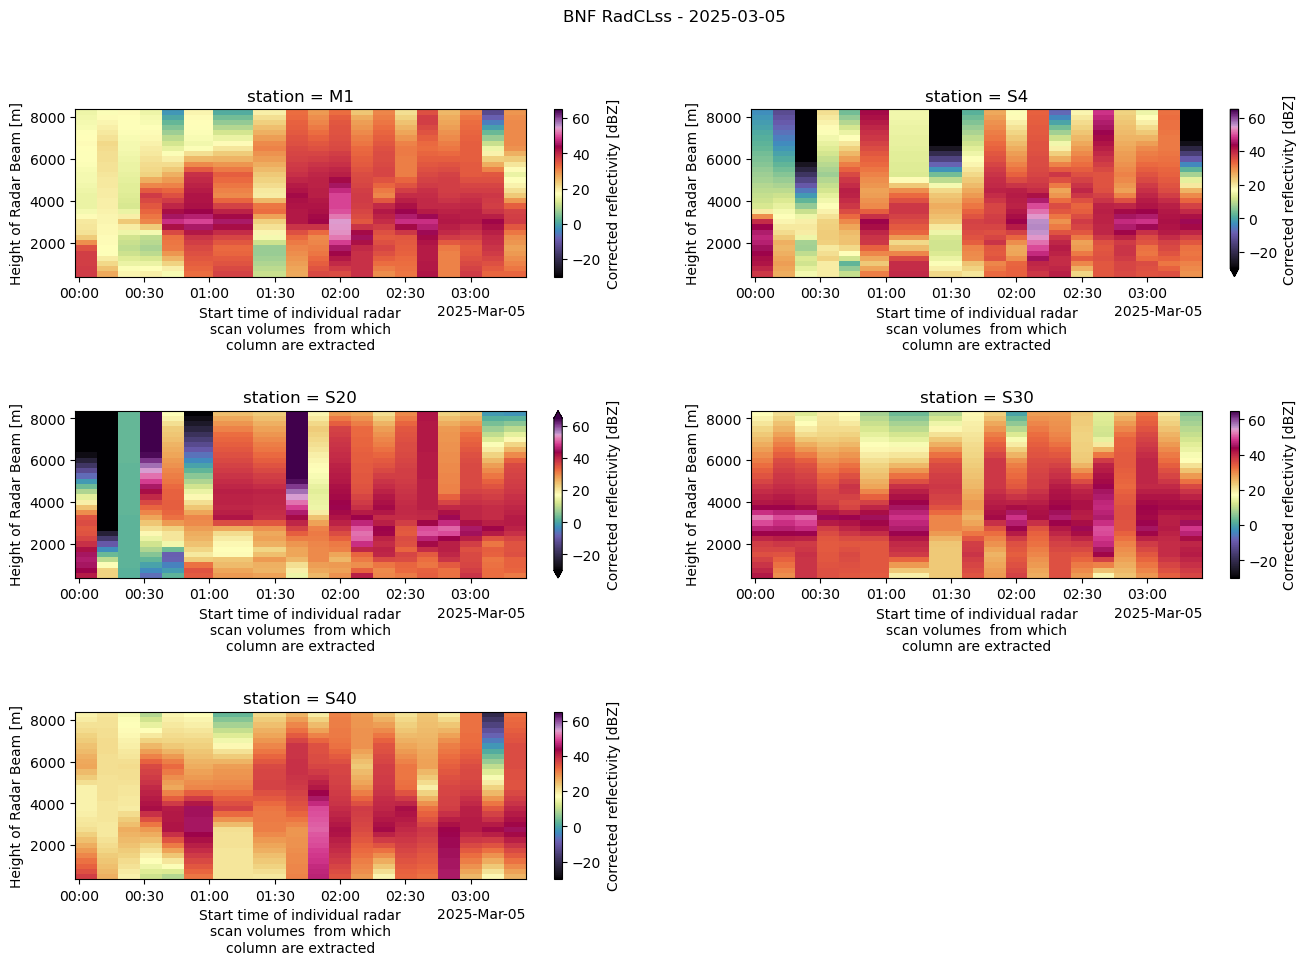

In [12]:
fig, axarr = plt.subplots(3, 2, figsize=[16, 10])
plt.subplots_adjust(hspace=0.8)

fig.suptitle("BNF RadCLss - " + DATE)

ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[0, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S4").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[0, 1], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S20").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[1, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S30").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[1, 1], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S40").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T03:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[2, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")

axarr[2, 1].set_visible(False)

## BNF Radar Display

Utilizing the OpenStreetMap tile, create a BNF centric display for overlaying
CMAC fields

In [13]:
# With the user defined RADAR_DIR, grab all the XPRECIPRADAR CMAC files for the defined DATE
file_list = sorted(glob.glob(RADAR_DIR + 'bnfcsapr2cmacS3.c1.' + DATE.replace('-', '') + '*.nc'))
file_list[20]

'/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.015003.nc'

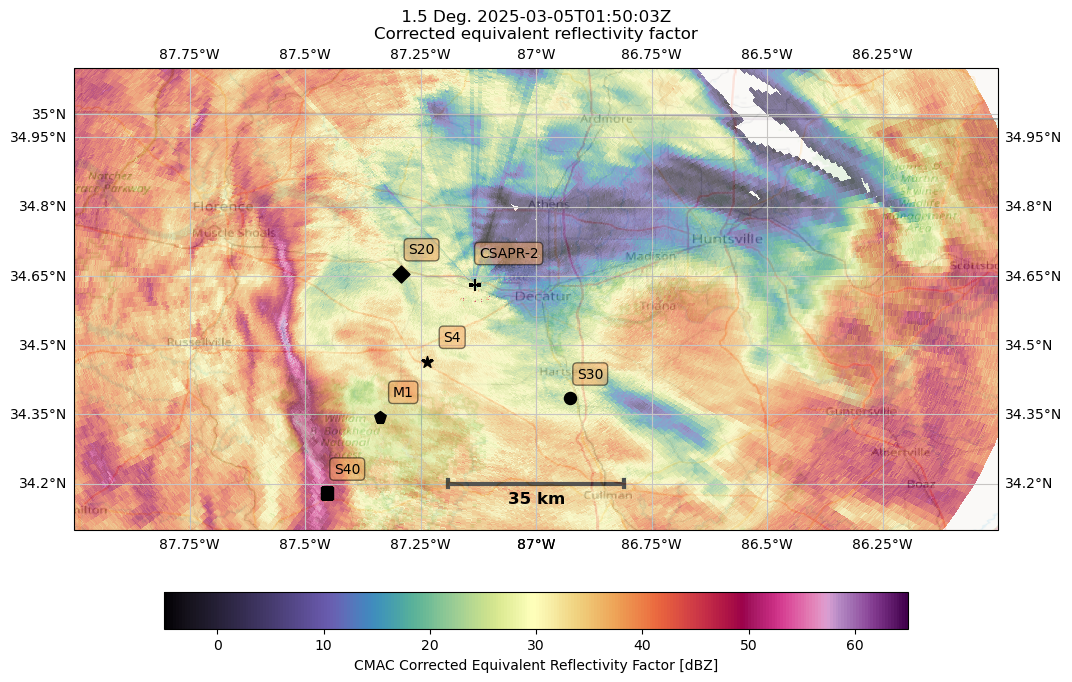

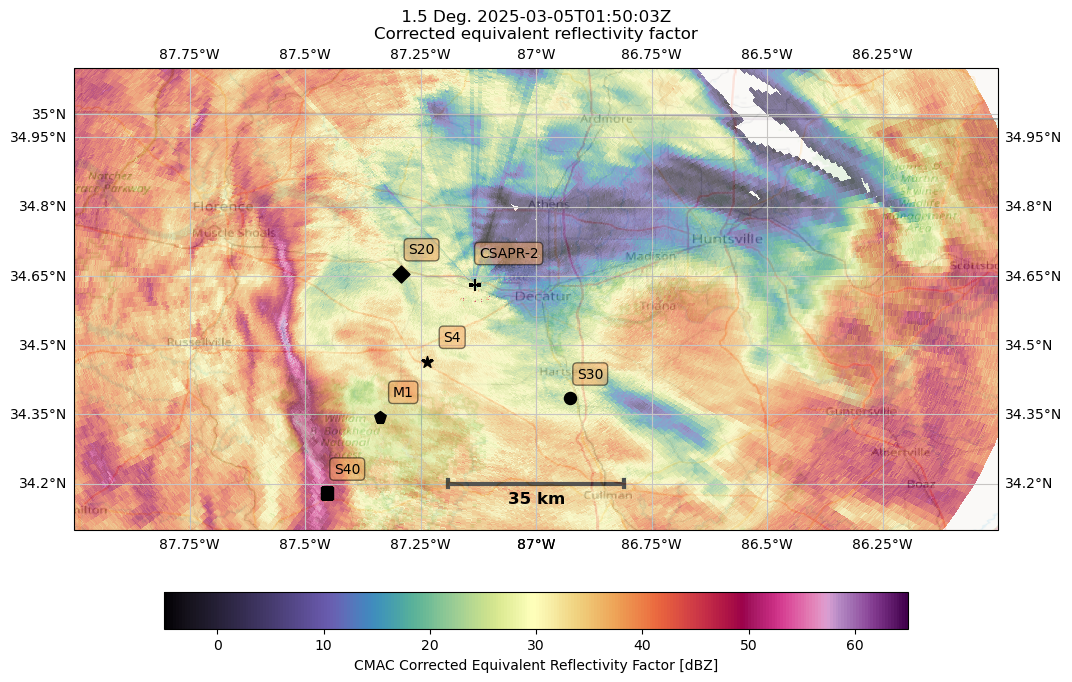

In [19]:
radar = pyart.io.read(file_list[20])
bnf_display(radar)

## References

### Surface Meteorological Instrumentation (MET)
- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**.
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Courtland **(S20)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Falkville **(S30)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Double Springs **(S40)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

### Balloon-Borne Sounding System (SONDEWNPN)
- Keeler, E., Burk, K., & Kyrouac, J. Balloon-Borne Sounding System (SONDEWNPN),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1595321

### Weighing Bucket Preciptiation Gauge (WBPLUVIO2)
- Zhu, Z., Wang, D., Jane, M., Cromwell, E., Sturm, M., Irving, K., & Delamere, J.
Weighing Bucket Precipitation Gauge (WBPLUVIO2), 2025-03-05 to 2025-03-05,
Bankhead National Forest, AL, USA; Long-term Mobile Facility (BNF), Bankhead
National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric Radiation Measurement
(ARM) User Facility. https://doi.org/10.5439/1338194

### Laser Disdrometer Quantities (LDQUANTS)
- Hardin, J., Giangrande, S., & Zhou, A. Laser Disdrometer Quantities (LDQUANTS),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1432694

- Hardin, J., Giangrande, S., & Zhou, A. Laser Disdrometer Quantities (LDQUANTS),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, Supplemental facility at Falkville
**(S30)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1432694